In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vmd import VMD
from envelope import spline_envelope

In [34]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [35]:
DS = pd.read_csv("DailyDelhiClimateTrain.csv", decimal=',')
DS['date'] = pd.to_datetime(DS['date'])
DS['meantemp'] = pd.to_numeric(DS['meantemp'])
DS.set_index("date", inplace=True)
DS.dropna(inplace=True)
TS = DS['meantemp']
TS

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64

In [36]:
index = TS.index
index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [37]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]


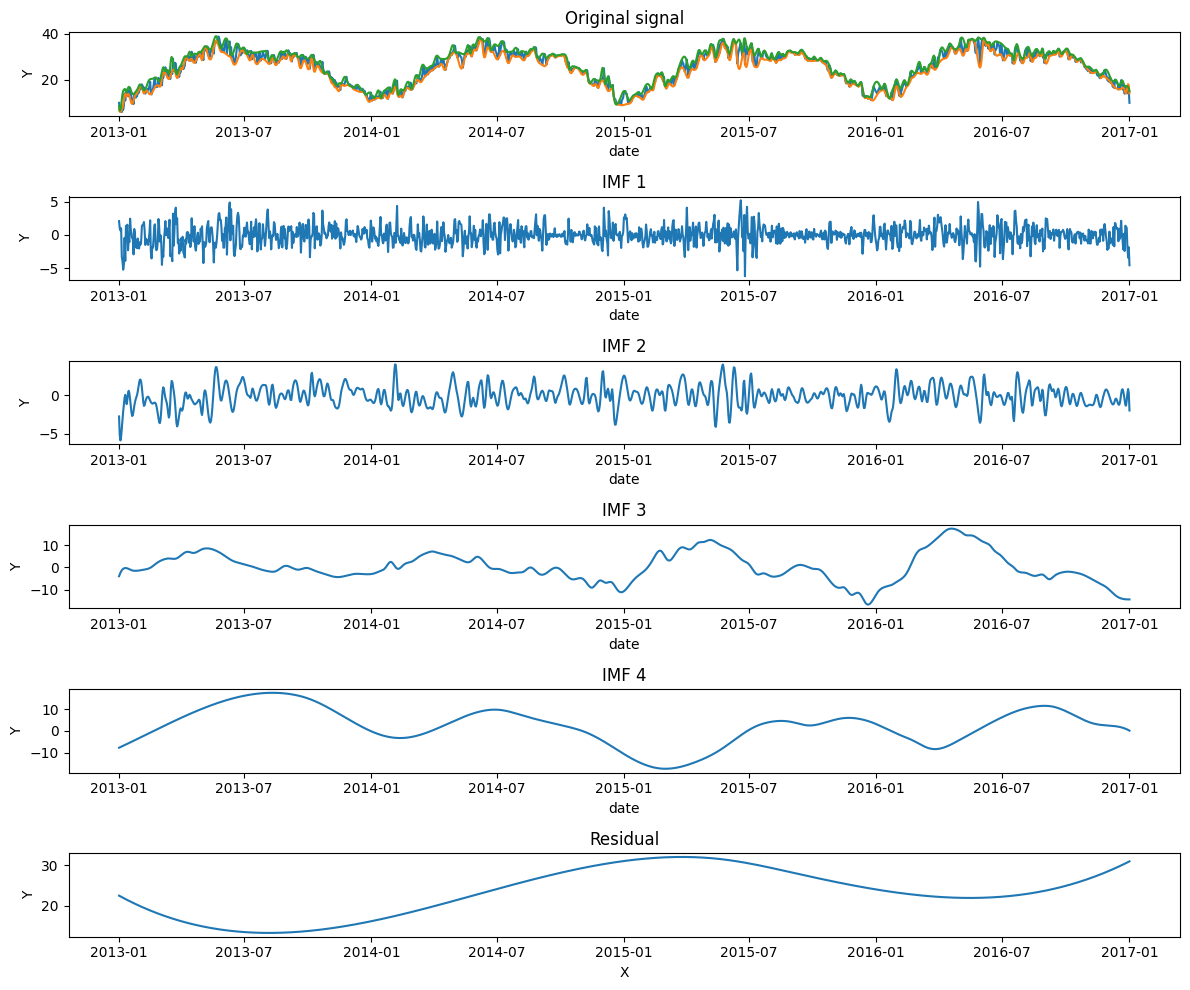

In [38]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

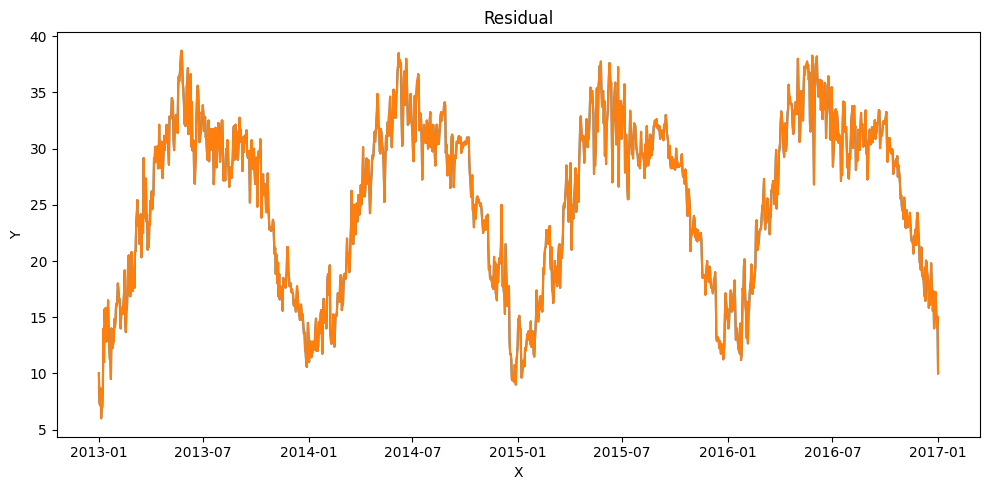

In [39]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(0,k):
    sum_imfs += u[i]

sum_imfs += f
axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [40]:
# Trend = f + u[3]+ u[2]
Season = u[1]
# Noise = u[0]

In [41]:
Season

array([-2.74062882, -5.17323577, -5.85047925, ...,  0.812215  ,
        0.29318224, -1.97216232], shape=(1462,))

# тестовый анализ

In [7]:
alpha = 1000
init = 1
DC = True
K = 5
tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

u, u_hat, omega = VMD(TS[0], alpha, tau, K, DC, init, tol)

featurecount = 6

Text(0.5, 0, 'X')

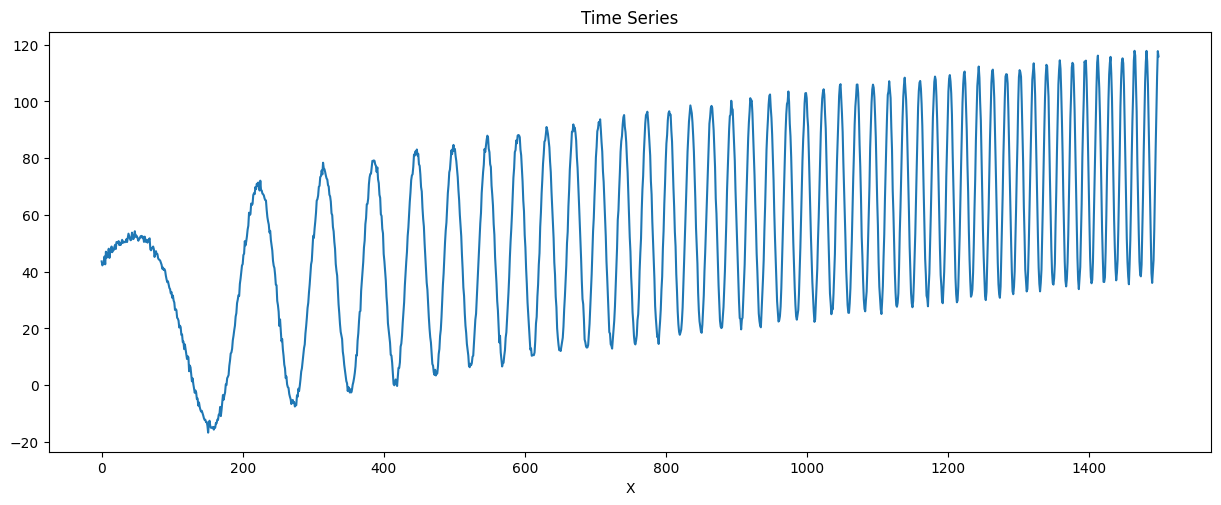

In [ ]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index, TS)
plt.title('Time Series')
plt.xlabel('X')

Text(0.5, 0, 'X')

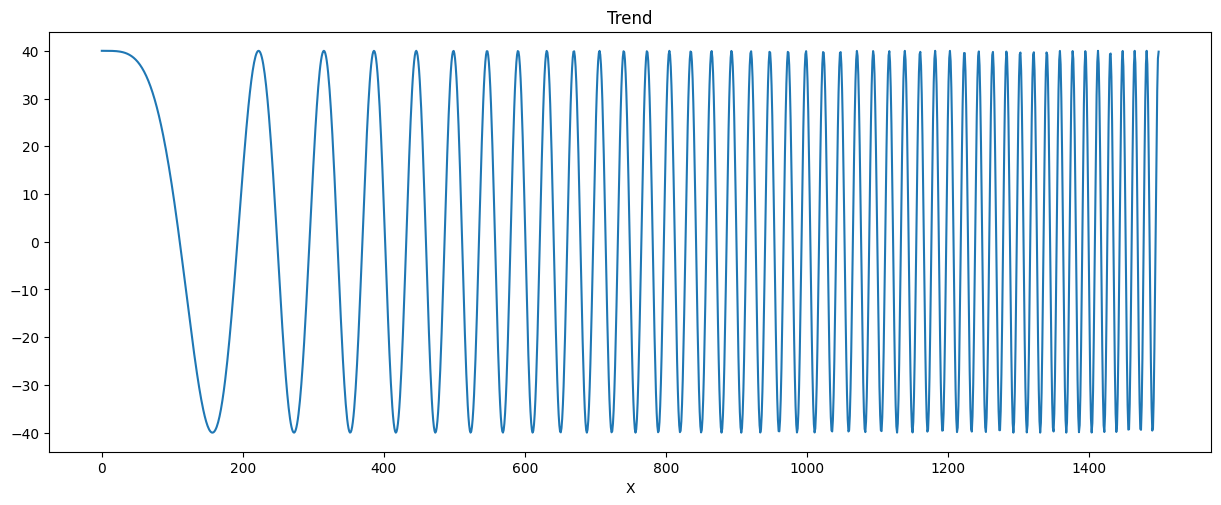

In [ ]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index, Season)
plt.title('Trend')
plt.xlabel('X')

In [32]:
sum_of_imfs = 0
i_imfs = K-2
for j in range(1, i_imfs+1):
    sum_of_imfs += u[j].T

In [34]:
r2_score(Season, sum_of_imfs)

0.8663624537396057

Text(0.5, 0, 'X')

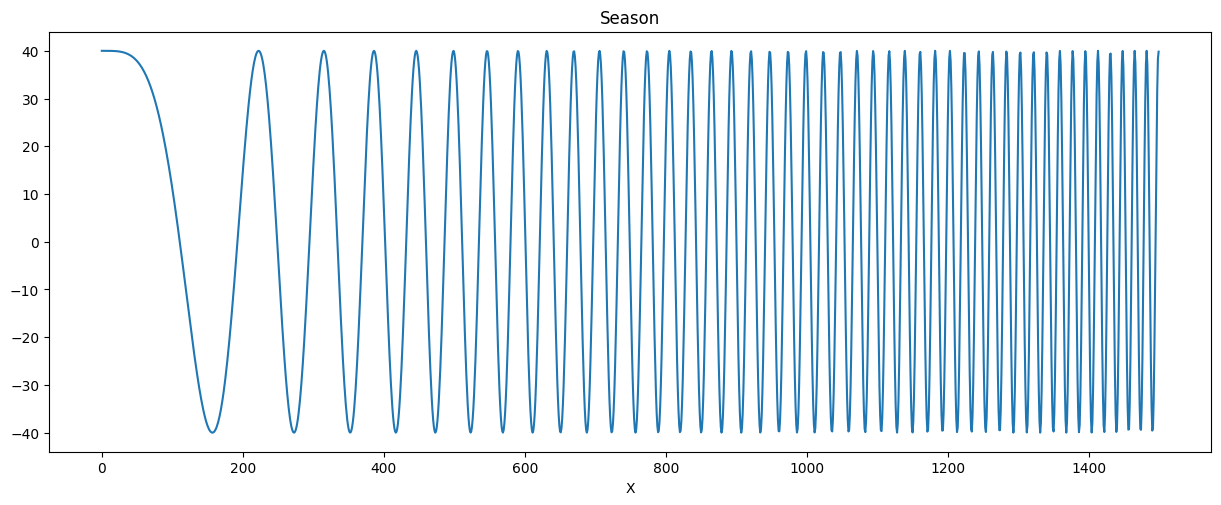

In [22]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Season)
plt.title('Season')
plt.xlabel('X')

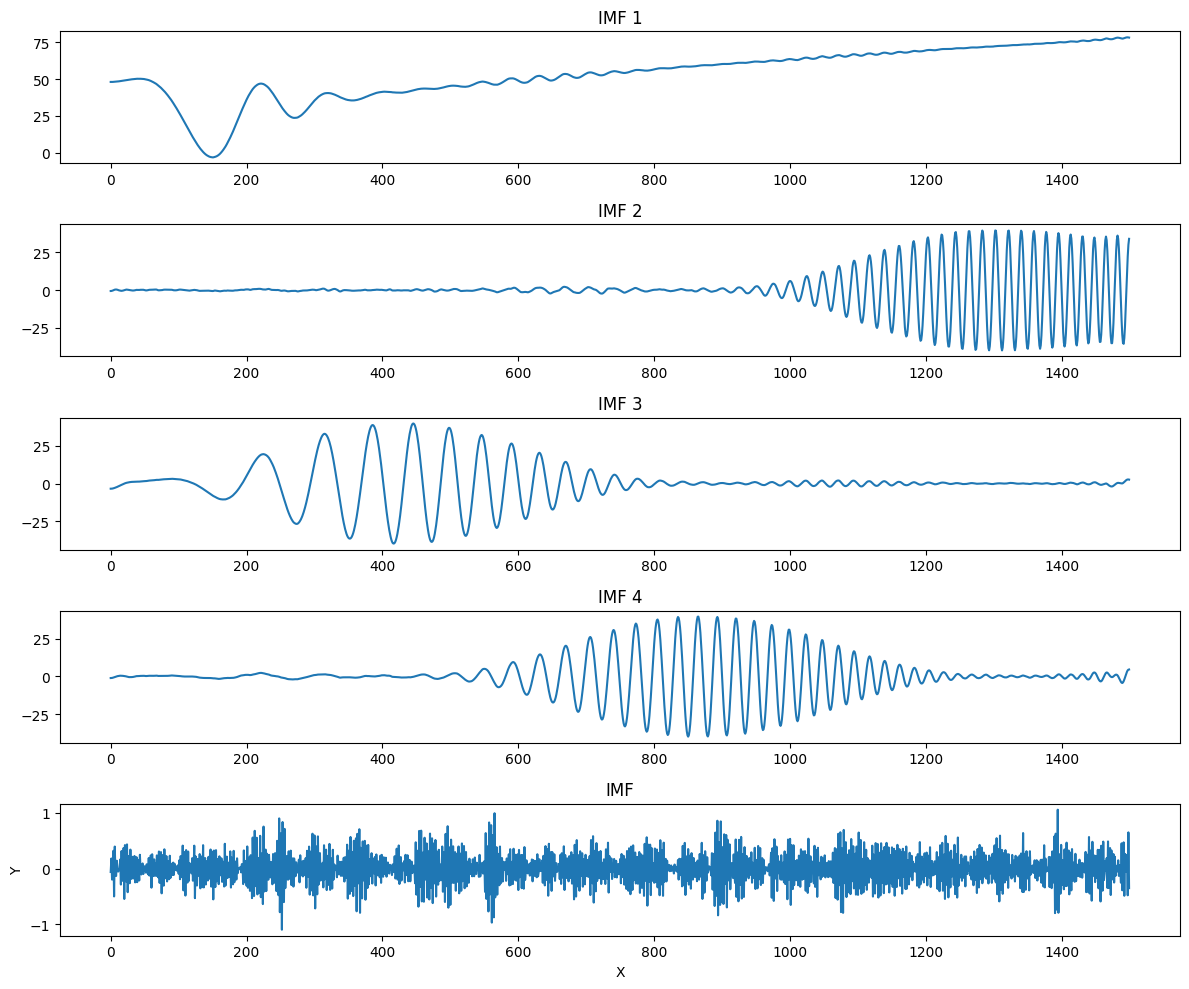

In [101]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range(K):
    axs[i].plot(index[0], u[i].T)
    axs[i].set_title(f'IMF {i+1}')

plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

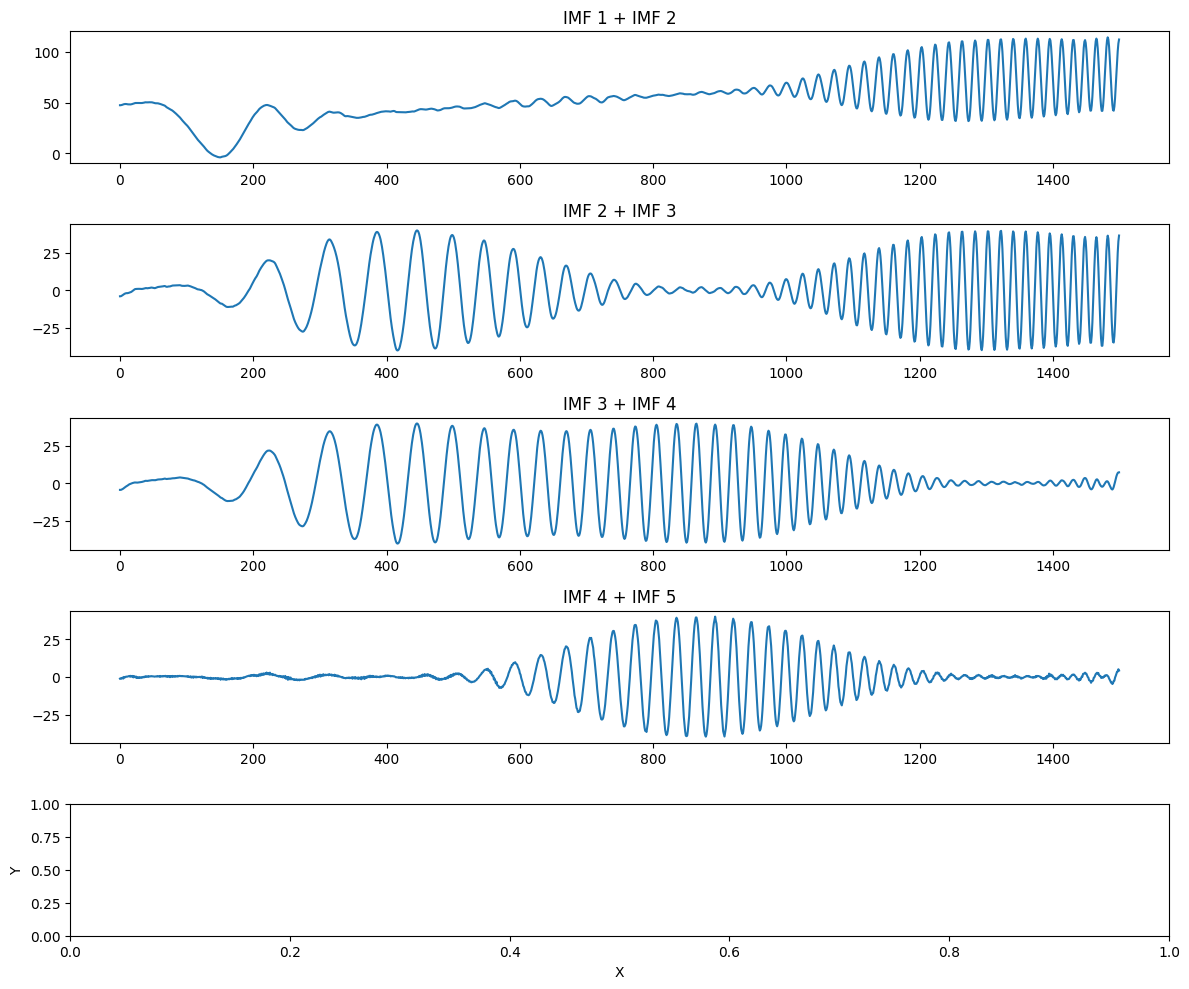

In [104]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range((K-1)):
    axs[i].plot(index[0], u[i].T + u[i+1].T)
    axs[i].set_title(f'IMF {i+1} + IMF {i+2}')

# plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# декомпозиция временного ряда

In [42]:
alpha = (0, 500, 1000, 5000, 10000, 20000)
init = (0, 1, 2)
DC = (False, True)
K = (3, 5, 7)
params_set = list(product(alpha, K, DC, init))

tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

featurecount = 6

In [43]:
best_metriks = {"Time Series": "Delhi temerature", "R2": -np.inf, "R2_Adj": -np.inf, "AIC" : np.inf, "BIC": np.inf}

best_r2_params = ({"Time Series": "Delhi temerature", "Metric": "R2", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
best_r2_adj_params = ({"Time Series": "Delhi temerature", "Metric": "R2_Adj", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
best_aic_params = ({"Time Series": "Delhi temerature", "Metric": "AIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
best_bic_params = ({"Time Series": "Delhi temerature", "Metric": "BIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 


In [44]:
j=0
r2_list = np.zeros((len(params_set), 2), dtype=float)
r2_adj_list = np.zeros((len(params_set), 2), dtype=float)
aic_list = np.zeros((len(params_set), 2), dtype=float)
bic_list = np.zeros((len(params_set), 2), dtype=float)
# для всех наборов параметров
for params_i in params_set:
    u, u_hat, omega = VMD(TS, params_i[0], tau, params_i[1], params_i[2], params_i[3], tol)
    
    k_i = params_i[1]
    r2 = list()
    r2_adj = list()
    aic = list()
    bic = list()
    sum_of_imfs = 0
    for i_imfs in range(1,k_i):
        sum_of_imfs += u[i_imfs].T

        r2.append(r2_score(Season, sum_of_imfs))
        r2_adj.append(r2_score_adjusted(Season, sum_of_imfs, featurecount))
        aic.append(calculate_aic(Season, sum_of_imfs, featurecount))
        bic.append(calculate_bic(Season, sum_of_imfs, featurecount))

    r2_list[j] = [np.max(r2), np.argmax(r2)]
    r2_adj_list[j] = [np.max(r2_adj), np.argmax(r2_adj)]
    aic_list[j] = [np.min(aic), np.argmin(aic)]
    bic_list[j] = [np.min(bic), np.argmin(bic)]

    j+=1

r2_list = np.transpose(r2_list)
max_r2 = np.max(r2_list[0])
argmax_r2 = np.argmax(r2_list[0])
i_imfs = int(r2_list[1][argmax_r2])
if (max_r2 > best_metriks["R2"]):
    best_metriks["R2"] = max_r2

    best_r2_params["alpha"] = params_set[argmax_r2][0]
    best_r2_params["K"] = params_set[argmax_r2][1]
    best_r2_params["DC"] = params_set[argmax_r2][2]
    best_r2_params["init"] = params_set[argmax_r2][3]
    best_r2_params["IMFs"] = f'2 - {i_imfs+2}'

r2_adj_list = np.transpose(r2_adj_list)
max_r2_adj = np.max(r2_adj_list[0])
argmax_r2_adj = np.argmax(r2_adj_list[0])
i_imfs = int(r2_adj_list[1][argmax_r2_adj])
if (max_r2_adj > best_metriks["R2_Adj"]):
    best_metriks["R2_Adj"] = max_r2_adj

    best_r2_adj_params["alpha"] = params_set[argmax_r2_adj][0]
    best_r2_adj_params["K"] = params_set[argmax_r2_adj][1]
    best_r2_adj_params["DC"] = params_set[argmax_r2_adj][2]
    best_r2_adj_params["init"] = params_set[argmax_r2_adj][3]
    best_r2_adj_params["IMFs"] = f'2 - {i_imfs+2}'

aic_list = np.transpose(aic_list)
min_aic = np.min(aic_list[0])
argmin_aic = np.argmin(aic_list[0])
i_imfs = int(aic_list[1][argmin_aic])
if (min_aic < best_metriks["AIC"]):
    best_metriks["AIC"] = min_aic

    best_aic_params["alpha"] = params_set[argmin_aic][0]
    best_aic_params["K"] = params_set[argmin_aic][1]
    best_aic_params["DC"] = params_set[argmin_aic][2]
    best_aic_params["init"] = params_set[argmin_aic][3]
    best_aic_params["IMFs"] = f'2 - {i_imfs+2}'

bic_list = np.transpose(bic_list)
min_bic = np.min(bic_list[0])
argmin_bic = np.argmin(bic_list[0])
i_imfs = int(bic_list[1][argmin_bic])
if (min_bic < best_metriks["BIC"]):
    best_metriks["BIC"] = min_bic

    best_bic_params["alpha"] = params_set[argmin_bic][0]
    best_bic_params["K"] = params_set[argmin_bic][1]
    best_bic_params["DC"] = params_set[argmin_bic][2]
    best_bic_params["init"] = params_set[argmin_bic][3]
    best_bic_params["IMFs"] = f'2 - {i_imfs+2}'

c:\Users\George\VS Code Projects\TS Generator\данные 1\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 1\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 1\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 1\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\данные 1\vmd.py:67: RuntimeWarning: invalid value encountered 

# метрики точности и параметры с выводом

In [45]:
filename=".\Output\\Best_Metriks-Season.csv"

fields = best_metriks.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    writer.writerows([best_metriks])  # Write data rows

In [46]:
filename=".\Output\\Parameters-Season.csv"

fields = best_r2_params.keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row

    writer.writerows([best_r2_params])  # Write data rows
    writer.writerows([best_r2_adj_params])  # Write data rows
    writer.writerows([best_aic_params])  # Write data rows
    writer.writerows([best_bic_params])  # Write data rows

